In [331]:
# coding=utf8

import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

plt.style.use(plt.style.available[0])

In [332]:
# 加载数据
df = pd.read_csv('data/DQC00-1d.txt',
                 sep=',',
                 nrows=5000,
                 index_col=['datetime'],  # 设置行索引
                 parse_dates=['datetime'],  # 解析时间 20100104130500.0
                 date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d%H%M%S.%f'),  # 时间解析的格式，进行毫秒级数据解析
                 usecols=['datetime', 'open', 'high', 'low', 'close', 'volume'],  # 设置需要用到的列
                 encoding='utf-8',
                 float_precision='round_trip',  # 所有数据会当做string读取, 使用时再进行相应的转换为float
                 )
# pd.reset_option('display.float_format')  # 重置
pd.set_option('precision', 2)  # 显示小数点后的位数
pd.set_option('display.max_rows', 300)  # 控制显示的最大行数
pd.set_option('display.min_rows', 20)  # 确定显示的部分有多少行
# pd.set_option('display.float_format',  '{:,.2f}'.format) # 数字格式化显示 用逗号格式化大值数字 设置数字精度
# 指定列名设置计算精确度，未指定的保持原样
df.round({'open': 0, 'high': 0, 'low': 0, 'close': 0})
# 统一保持1位小数
df.round(0)
# 设置np输出精度
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=2, suppress=True)

In [333]:
print(df.dtypes)
df.head()

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


,open,high,low,close,volume
datetime,,,,,
2004-09-22,1143.23,1147.88,1106.05,1106.98,77908.0
2004-09-23,1097.68,1099.54,1089.32,1093.04,37196.0
2004-09-24,1082.81,1101.40,1082.81,1095.83,29367.0
2004-09-27,1092.11,1100.47,1075.38,1076.31,17336.0
2004-09-28,1077.24,1088.39,1077.24,1082.81,26681.0


In [334]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
#Flase:对应特征的特征值中无缺失值
#True：有缺失值
print(df.isnull().any())
print(np.isnan(df).any())
#返回每一列缺失值统计个数
print(df.isnull().sum())

open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [335]:
#缺失值处理，以下两种方式均可
#删除包含缺失值的行
df.dropna(inplace=True)
#缺失值填充
# df.fillna('100')

#返回每一列缺失值统计个数
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [336]:
# 截取时间段内样本数据
df = df["2021-01-01":]
print(df[:3])
# 2.2 确定特征值 目标值
# 特征值取开盘价和收盘价的差值
# X = (df[['open']]).values
X = (df[['open', 'high', 'low']]).values
print(type(X), X.shape, X.ndim)

print(X[:3, ])

               open     high      low    close    volume
datetime                                                
2021-01-04  2664.50  2687.72  2650.96  2655.80  633210.0
2021-01-05  2654.83  2686.75  2654.83  2678.04  472285.0
2021-01-06  2683.85  2706.09  2679.01  2694.49  481959.0
<class 'numpy.ndarray'> (213, 3) 2
[[2664.5  2687.72 2650.96]
 [2654.83 2686.75 2654.83]
 [2683.85 2706.09 2679.01]]


In [337]:
# 目标值取开盘价和收盘价的差值
# y = df.iloc[:, -2:-1].values.ravel()
Y = (df['close']).values
print(Y.shape)
print(Y.ndim)
print(Y[:3])


(213,)
1
[2655.8  2678.04 2694.49]


In [338]:
#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y.reshape(-1, 1),
                                                    random_state=None,
                                                    test_size=0.50,  #测试集50%样本数量
                                                    shuffle=True,  #default=True 切分前是否对数据进行打乱。
                                                    )


In [339]:
print(x_train.shape, y_train.shape, y_train.ndim)
print(x_test.shape, y_test.shape, y_test.ndim)
np.hstack((x_test, y_test))[:3]

(106, 3) (106, 1) 2
(107, 3) (107, 1) 2


array([[2672.24, 2693.52, 2652.9 , 2684.81],
       [2687.  , 2688.  , 2664.  , 2679.  ],
       [2571.  , 2583.  , 2560.  , 2568.  ]])

In [340]:
## 混淆测试集目标类别的 指定概率50%的错误
err = x_train
for i in range(int(len(err) * 0.0)):
    index = int(np.random.randint(len(err)))
    # index2 = int(np.random.randint(len(err)))
    # err[index,0], err[index,3] = err[index,3], err[index,0]
    err[index] = 0

In [341]:
# 3. 特征工程（标准化）
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

x_train_stand = standardScaler.fit_transform(x_train)
x_test_stand = standardScaler.transform(x_test)

y_train_stand = standardScaler.fit_transform(y_train)
y_test_stand = standardScaler.transform(y_test)

In [342]:
print(x_train.shape)
print(x_train.ndim)
print(y_train.shape)
print(y_train.ndim)
print(x_train[:10])
print(x_train[:10, 0])

(106, 3)
2
(106, 1)
2
[[2629.69 2641.29 2614.21]
 [2510.   2510.   2480.  ]
 [2603.   2617.   2585.  ]
 [2459.   2484.   2455.  ]
 [2675.14 2694.49 2673.21]
 [2737.36 2755.15 2712.66]
 [2670.16 2691.9  2658.3 ]
 [2640.33 2647.1  2615.18]
 [2501.18 2524.9  2495.25]
 [2574.56 2579.39 2546.51]]
[2629.69 2510.   2603.   2459.   2675.14 2737.36 2670.16 2640.33 2501.18
 2574.56]


In [343]:
#画图观察
# fig, ax = plt.subplots()
# ax.scatter(y_test_stand, x_test_stand)
# ax.plot([y_test_stand.min(), y_test_stand.max()], [y_test_stand.min(), y_test_stand.max()], 'k--', lw=2)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()

In [344]:
epsilon = 0.18
c = 1.0
# 拟合回归模型
svr_rbf = SVR(kernel='rbf', C=c, gamma=1, epsilon=epsilon)
svr_lin = SVR(kernel='linear', C=c, gamma='auto', epsilon=epsilon)
svr_poly = SVR(kernel='poly', C=c, gamma='auto', epsilon=epsilon,
               degree=3,  #默认=3 多项式核函数的次数(' poly ')。将会被其他内核忽略。
               coef0=0.1,  #默认=0.0 核函数中的独立项。它只在' poly '和' sigmoid '中有意义
               )

In [345]:
x_train.shape, x_test.shape
# np.vstack((x_train,x_test)).shape

((106, 3), (107, 3))

ix=0, svcs=SVR(epsilon=0.18, gamma=1)
估计器参数: kernel=rbf, C=1.0, epsilon=0.18
svm: (20, 3) epsilon:0.18 = [[16.82]] e_i:[[16.82]] sv/e:[[1009.36]]
epsilon mean: 11.28 std: 14.45 max: 40.71 min: 0.01
svm间隔 mean: 103.27 std: 116.92 max: 211.9 min: 1.67 e_sum: [[1737.35]]
std与误差范围占比%: 0.36  var方差: 208.8
std与误差范围占比%: 0.56
训练集评分: 0.9787580290933608 
测试集评分: 0.9725109038548155 
ix=1, svcs=SVR(epsilon=0.18, gamma='auto', kernel='linear')
估计器参数: kernel=linear, C=1.0, epsilon=0.18
svm: (12, 3) epsilon:0.18 = [[16.82]] e_i:[[16.82]] sv/e:[[605.62]]
epsilon mean: 10.05 std: 12.31 max: 36.94 min: 0.03
svm间隔 mean: 77.9 std: 82.64 max: 145.67 min: 11.93 e_sum: [[1310.55]]
std与误差范围占比%: 0.33  var方差: 151.49
std与误差范围占比%: 0.62
训练集评分: 0.9865986822971643 
测试集评分: 0.9799871405611589 
ix=2, svcs=SVR(coef0=0.1, epsilon=0.18, gamma='auto', kernel='poly')
估计器参数: kernel=poly, C=1.0, epsilon=0.18
svm: (48, 3) epsilon:0.18 = [[16.82]] e_i:[[16.82]] sv/e:[[2422.47]]
epsilon mean: 16.67 std: 20.54 max: 51.52 min: 0.09


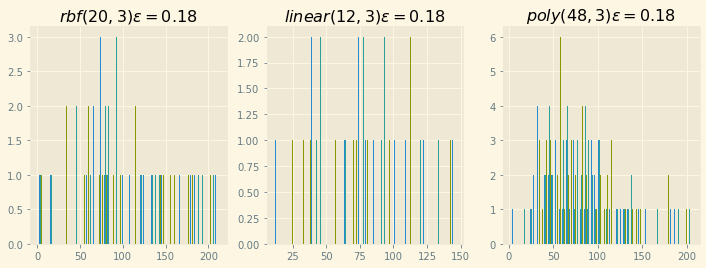

In [346]:
plt.figure(figsize=(12, 4))
xx = np.vstack((x_train_stand[:, ], x_test_stand[:, ]))
yy = np.vstack((y_train_stand, y_test_stand))
x_min, x_max = xx.min() - 0.5, xx.max() + 0.5
y_min, y_max = yy.min() - 0.5, yy.max() + 0.5

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["rbf", "linear", "poly"]
for ix, svr in enumerate(svrs):
    fit = svr.fit(x_train_stand, y_train_stand.ravel())
    # 获取预测值
    y_test_pred = fit.predict(x_test_stand)
    # 显示估计器
    print(f'ix=%s, svcs=%s' % (ix, svrs[ix]))
    # 获取这个估计器的参数
    svr_params = svr.get_params()
    print(f'估计器参数: kernel=%s, C=%s, epsilon=%s' % (
        svr_params.get('kernel'), svr_params.get('C'), svr_params.get('epsilon')))

    epsilon_1 = standardScaler.inverse_transform(np.array([[fit.epsilon], ]))  #转换误差单位
    epsilon_0 = standardScaler.inverse_transform(np.array([[0.00], ]))
    epsilon_i = ((epsilon_1 - epsilon_0))  #目标误差值
    sv = fit.support_vectors_.shape  #支持向量
    sv_e_sum = (sv[0] * sv[1]) * epsilon_i  #所有支持向量的误差和
    print('svm:', fit.support_vectors_.shape,  #支持向量个数
          'epsilon:%s = %s' % (fit.epsilon, epsilon_1 - epsilon_0),  #误差值
          'e_i:%s' % (epsilon_i),  #误差值
          'sv/e:%s' % (sv_e_sum)
          )
    y_test_pred_ = standardScaler.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_ = standardScaler.inverse_transform(y_test_stand.reshape(-1, 1))
    y_test_d = (y_test_ - y_test_pred_)  #epsilon误差
    y_test_d_max, y_test_d_min = abs(y_test_d).max(), abs(y_test_d).min()  #误差最大值和最小值
    print('epsilon mean:', np.mean(abs(y_test_d)).round(2),  #epsilon误差平均值
          'std:', np.std(y_test_d).round(2),  #标准差
          'max:', (y_test_d_max).round(2),
          'min:', y_test_d_min.round(2),
          )

    support_vectors_ = standardScaler.inverse_transform(fit.support_vectors_)
    support_vectors_d = support_vectors_ - epsilon_0  #svm间隔
    support_vectors_d_max, support_vectors_d_min = abs(support_vectors_d).max(), abs(
        support_vectors_d).min()  #svm间隔最大值和最小值
    svm_mean_e_sum = np.mean(abs(support_vectors_d)) * epsilon_i  #svm误差和

    print('svm间隔 mean:', np.mean(abs(support_vectors_d)).round(2),  #平均值
          'std:', np.std((support_vectors_d)).round(2),  #标准差
          'max:', support_vectors_d_max.round(2),
          'min:', support_vectors_d_min.round(2),
          'e_sum:', (svm_mean_e_sum)
          )
    print("std与误差范围占比%:", (np.std(y_test_d) / (y_test_d_max - y_test_d_min)).round(2),  #标准差std与误差范围占比%
          ' var方差:', np.var(y_test_d).round(2))
    print('std与误差范围占比%:',
          (np.std(support_vectors_d) / (support_vectors_d_max - support_vectors_d_min)).round(2))  #标准差std与误差范围占比%

    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集评分: %s ' % (fit.score(x_train_stand, y_train_stand)))
    print(f'测试集评分: %s ' % (svr.score(x_test_stand, y_test_stand)))

    plt.subplot(1, 3, ix + 1)
    interval = abs(support_vectors_ - epsilon_0)
    plt.hist(interval, bins=50)
    plt.title(r'$%s %s \epsilon = %s$' % (fit.kernel, fit.support_vectors_.shape, fit.epsilon))

plt.show()
# plt.savefig(r'./file/02_svm_svr.png', dpi=200)



sv: (12, 3)
epsilon:0.18 = [[16.82]]
epsilon mean平均值: 10.05
epsilon std标准差: 12.31
epsilon std标准差: 12.31
epsilon var方差: 151.49
svm mean平均值 77.9
svm std标准差 82.64
#查看切分后的数据与切分前的数据是否一致 [[2735.11 2735.11 2680.95]
 [2560.47 2560.47 2705.12]
 [2570.35 2570.35 2620.98]
 [2498.21 2498.21 2550.38]
 [2655.8  2655.8  2544.58]]
#查看训练集的sv支持向量(12, 3) [[2690.62 2738.98 2674.18 2689.32 2717.49 2694.29]
 [2541.7  2564.42 2513.04 2539.4  2546.57 2526.85]
 [2585.18 2598.02 2569.37 2583.17 2579.47 2585.38]
 [2545.65 2557.51 2497.23 2543.38 2539.8  2510.42]
 [2664.5  2687.72 2650.96 2663.03 2667.3  2670.17]
 [2481.   2520.   2471.   2478.29 2503.08 2483.17]
 [2725.43 2736.07 2659.67 2724.37 2714.65 2679.21]
 [2735.11 2738.98 2684.81 2734.1  2717.49 2705.34]
 [2746.71 2780.56 2714.8  2745.79 2758.21 2736.49]
 [2700.29 2722.53 2677.08 2699.05 2701.39 2697.3 ]]
查看预测值与目标值的差值 [[2672.24 2693.52 2652.9     2.44  -18.84   21.78   12.57   -8.7    31.92
    10.13]
 [2687.   2688.   2664.    -11.64  -12.64   11.36   -

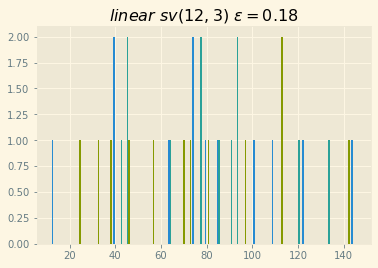

In [347]:
svrs = [svr_rbf, svr_lin, svr_poly]

fit = svrs[1]

print('sv:', fit.support_vectors_.shape)
epsilon_1 = standardScaler.inverse_transform(np.array([[fit.epsilon], ]))
epsilon_0 = standardScaler.inverse_transform(np.array([[0.00], ]))
print('epsilon:%s = %s' % (fit.epsilon, epsilon_1 - epsilon_0))

y_test_pred = fit.predict(x_test_stand)
y_test_pred_ = standardScaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test_ = standardScaler.inverse_transform(y_test_stand.reshape(-1, 1))
print('epsilon mean平均值:', np.mean(abs((y_test_ - y_test_pred_))).round(2))
print('epsilon std标准差:', np.std(((y_test_ - y_test_pred_))).round(2))
print('epsilon std标准差:', np.std((y_test_ - y_test_pred_)).round(2))
print('epsilon var方差:', np.var(((y_test_ - y_test_pred_))).round(2))
support_vectors_ = standardScaler.inverse_transform(fit.support_vectors_)
print('svm mean平均值', np.mean(abs(support_vectors_ - epsilon_0)).round(2))
print('svm std标准差', np.std((support_vectors_ - epsilon_0)).round(2))

y_train_ = standardScaler.inverse_transform(y_train_stand.reshape(-1, 1))
print('#查看切分后的数据与切分前的数据是否一致', (np.hstack(((y_train[fit.support_]), (y_train_[fit.support_]),
                                          (Y[:len(y_train)][fit.support_].reshape(-1, 1)))))[:5])
print('#查看训练集的sv支持向量%s %s' % (
    fit.support_vectors_.shape, np.hstack((((x_train)[fit.support_]), (support_vectors_)))[:10]))

print('查看预测值与目标值的差值', (np.hstack((x_test, (y_test_pred_ - x_test), (y_test_ - x_test), (y_test - y_test_pred_)))[:5]))

interval = abs(support_vectors_ - epsilon_0)
plt.hist(interval, bins=50)
plt.title(r'$%s\ sv%s\ \epsilon = %s$' % (fit.kernel, fit.support_vectors_.shape, fit.epsilon))
plt.show()

In [348]:
print('epsilon_0', epsilon_0)
print('#查看训练集的支持向量%s %s' % (fit.support_vectors_.shape, np.hstack((((x_train)[fit.support_]), (support_vectors_)))[:]))

epsilon_0 [[2623.96]]
#查看训练集的支持向量(12, 3) [[2690.62 2738.98 2674.18 2689.32 2717.49 2694.29]
 [2541.7  2564.42 2513.04 2539.4  2546.57 2526.85]
 [2585.18 2598.02 2569.37 2583.17 2579.47 2585.38]
 [2545.65 2557.51 2497.23 2543.38 2539.8  2510.42]
 [2664.5  2687.72 2650.96 2663.03 2667.3  2670.17]
 [2481.   2520.   2471.   2478.29 2503.08 2483.17]
 [2725.43 2736.07 2659.67 2724.37 2714.65 2679.21]
 [2735.11 2738.98 2684.81 2734.1  2717.49 2705.34]
 [2746.71 2780.56 2714.8  2745.79 2758.21 2736.49]
 [2700.29 2722.53 2677.08 2699.05 2701.39 2697.3 ]
 [2700.8  2707.72 2636.56 2699.57 2686.88 2655.2 ]
 [2637.55 2689.93 2630.63 2635.9  2669.46 2649.04]]


In [349]:
# fit = svr_rbf
print('support_支持向量的下标', fit.support_.shape)
print('support_vectors_支持向量', fit.support_vectors_.shape)
print('n_support_每个类别的支持向量数量', fit.n_support_)
print('dual_coef_决策函数中支持向量的系数', fit.dual_coef_.shape)
print('intercept_决策函数中的常量', fit.intercept_)

support_支持向量的下标 (12,)
support_vectors_支持向量 (12, 3)
n_support_每个类别的支持向量数量 [12]
dual_coef_决策函数中支持向量的系数 (1, 12)
intercept_决策函数中的常量 [0.03]
